# Choice of decarboxylation enzyme under changing volume constraints

## Heatmap vizualisation

### Imports

In [28]:
import pandas as pd
from cobra.io import read_sbml_model
from cobra import flux_analysis
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("../Code")
from model_functions import *

### Reading and constraining C4 model

In [29]:
"""
Read and prepare C4 model
"""

c4_model = read_sbml_model("../Models/c4_model.xml")

c4_model.solver = "glpk"

c4_model.objective = '[M]_Maize_biomass_tx'

#Setting up Rubisco carboxylase/oxygenase (3:1) ratio in C4 model
const = c4_model.problem.Constraint(
    3 * c4_model.reactions.get_by_id("[M]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id(
        "[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression, lb=0, ub=0)
c4_model.add_cons_vars(const)

const = c4_model.problem.Constraint(
    3 * c4_model.reactions.get_by_id("[B]_RXN_961_p").flux_expression - 1 * c4_model.reactions.get_by_id(
        "[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_Ex").flux_expression, lb=0, ub=0)
c4_model.add_cons_vars(const)

#Block Mesophyll and Bundle Sheath "External" Rubisco
set_bounds("[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p", (0, 0), c4_model)
#set_bounds("[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_Ex", (0,0), c4_model)


def c4_maintenance(c4_model):
    #Constrains for light dependent maintenance costs
    atp_b = c4_model.reactions.get_by_id("[B]_ATPase_tx")
    photon_b = c4_model.reactions.get_by_id("[B]_Photon_tx")
    atp_m = c4_model.reactions.get_by_id("[M]_ATPase_tx")
    photon_m = c4_model.reactions.get_by_id("[M]_Photon_tx")

    const_b = c4_model.problem.Constraint((0.0049 * photon_b.flux_expression + 2.7852) - atp_b.flux_expression, lb=0,
                                          ub=0)
    c4_model.add_cons_vars(const_b)

    const_m = c4_model.problem.Constraint((0.0049 * photon_m.flux_expression + 2.7852) - atp_m.flux_expression, lb=0,
                                          ub=0)
    c4_model.add_cons_vars(const_m)
    # ATP/NADPH 3:1 constraints
    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[B]_ATPase_tx").flux_expression - 3 * (
                c4_model.reactions.get_by_id("[B]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id(
            "[B]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxm_tx").flux_expression), lb=0,
                                        ub=0)
    c4_model.add_cons_vars(const)

    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[M]_ATPase_tx").flux_expression - 3 * (
                c4_model.reactions.get_by_id("[M]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id(
            "[M]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxm_tx").flux_expression), lb=0,
                                        ub=0)
    c4_model.add_cons_vars(const)


#Add Light dependent maintenance
c4_maintenance(c4_model)

No objective coefficients in model. Unclear what should be optimized


### Performing Flux simulations

#### Initial C4 simulation function

In [30]:
def simul_c4(light, nitrogen, carbon, light_ratio = 1, volume_ratio = 1):
     with c4_model:
        c4_model.objective = "[M]_Maize_biomass_tx" # Objective funtion established as Maize Biomass
        c4_model.solver = "glpk" # Setting up the solver

        # Adding constrains for model inputs
        medium = c4_model.medium
        medium["[M]_CO2_tx"] = carbon
        medium["[B]_Nitrate_tx"] = nitrogen
        c4_model.medium = medium

        # Implementation of the volume constrain occurs through constraining the exchange fluxes between the cell types in such a way that
        # [MB]_Metabolite_tx: 1 [M]_Metabolite_c <--> (1/Volume Ratio) [B]_Metabolite_c
        for reaction in c4_model.reactions:
            if reaction.id[0:4] == "[MB]":
                dict = {reaction.products[0] : -(1/volume_ratio)}
                reaction.subtract_metabolites(dict, combine=False)


        # Usage of the absolute values implies the consideration of the effect of the Volume Ratio on  light uptake into the bundle sheath  ([B]_Photon_tx * Volume Ratio)
        # previous to flux simulation and therefore its effect on Total Photon Uptake and on AB BS/M
        # This is achieved by considering this volume ratio in Total Light Uptake and AB BS/M by the model using the formulas below.
        set_bounds("[M]_Photon_tx", ((light/(light_ratio+1)), light/(light_ratio+1)), c4_model)
        set_bounds("[B]_Photon_tx", ((abs(light-(light/(light_ratio+1))))/volume_ratio, (abs(light-(light/(light_ratio+1))))/volume_ratio), c4_model)


        solution = flux_analysis.pfba(c4_model)

        solution_frame = solution.to_frame()

        # Fluxes for decarboxylation enzymes (in the bundle sheath) are normalized through multiplication by the volume ratio
        NADP_ME = solution_frame.loc["[B]_MALIC_NADP_RXN_p"]["fluxes"] * volume_ratio
        PEP_CK = solution_frame.loc["[B]_PEPCARBOXYKIN_RXN_c"]["fluxes"] * volume_ratio
        NAD_ME = solution_frame.loc["[B]_1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m"]["fluxes"] * volume_ratio
        GLY_DX = solution_frame.loc["[B]_GCVMULTI_RXN_m"]["fluxes"] * volume_ratio
        B_photon = solution_frame.loc["[B]_Photon_tx"]["fluxes"] #Photon uptake fluxes are normalized to "absolute" flux values later on
        M_photon = solution_frame.loc["[M]_Photon_tx"]["fluxes"]
        CO2 = solution_frame.loc["[M]_CO2_tx"]["fluxes"]
        return (NADP_ME, PEP_CK, NAD_ME, B_photon, M_photon, GLY_DX, CO2)


### Flux Simulations

#### Parameter Range

In [31]:
list_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

volume_ratio = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#### $P_{Total} = 250 \mu mol s^{-1}$

In [32]:

NADP_ME = []
NAD_ME = []
PEP_CK = []
B_photon = []
M_photon = []
Volume_Ratio = []
GLY_DX = []
CO2 = []
C4 = []
AB = []

for r in list_ratio:
    for volume in volume_ratio:
        tuple = (simul_c4(light = 250, nitrogen=1000, light_ratio = r, volume_ratio = volume, carbon = 40))
        NADP_ME.append(tuple[0]/(tuple[6]))
        PEP_CK.append(tuple[1]/(tuple[6]))
        NAD_ME.append(tuple[2]/(tuple[6]))
        C4.append(tuple[0]/(tuple[6]) + tuple[1]/(tuple[6]) + tuple[2]/(tuple[6]) + tuple[5]/(tuple[6]))
        B_photon.append(tuple[3]*volume) #Multiplication by the volume ratio to obtain "absolute" bundle sheath photon uptake
        M_photon.append(tuple[4])
        AB.append(round(tuple[3] * volume/tuple[4],1)) #Multiplication by the volume ratio to obtain "absolute" bundle sheath photon uptake
        GLY_DX.append(tuple[5]/(tuple[6]))
        CO2.append(tuple[6])
        Volume_Ratio.append(volume)


list_of_tuples = list(zip(NADP_ME, PEP_CK, NAD_ME, GLY_DX, B_photon, M_photon, AB, Volume_Ratio, CO2, C4))
df_250 = pd.DataFrame(list_of_tuples,
                  columns = ['NADP-ME', 'PEP-CK', "NAD-ME", "GLY-DX","Photon BS", "Photon M", "AB (BS/M)", "Volume Ratio", "CO2 uptake", "C4 Photosynthesis"])

#### $P_{Total} = 500 \mu mol s^{-1}$

In [33]:
NADP_ME = []
NAD_ME = []
PEP_CK = []
B_photon = []
M_photon = []
Volume_Ratio = []
GLY_DX = []
CO2 = []
C4 = []
AB = []

for r in list_ratio:
    for volume in volume_ratio:
        tuple = (simul_c4(light = 500, nitrogen=1000, light_ratio = r, volume_ratio = volume, carbon = 40))
        NADP_ME.append(tuple[0]/(tuple[6]))
        PEP_CK.append(tuple[1]/(tuple[6]))
        NAD_ME.append(tuple[2]/(tuple[6]))
        C4.append(tuple[0]/(tuple[6]) + tuple[1]/(tuple[6]) + tuple[2]/(tuple[6]) + tuple[5]/(tuple[6]))
        B_photon.append(tuple[3]*volume) #Multiplication by the volume ratio to obtain "absolute" bundle sheath photon uptake
        M_photon.append(tuple[4])
        AB.append(round(tuple[3] * volume/tuple[4],1)) #Multiplication by the volume ratio to obtain "absolute" bundle sheath photon uptake
        GLY_DX.append(tuple[5]/(tuple[6]))
        CO2.append(tuple[6])
        Volume_Ratio.append(volume)


list_of_tuples = list(zip(NADP_ME, PEP_CK, NAD_ME, GLY_DX, B_photon, M_photon, AB, Volume_Ratio, CO2, C4))
df_500 = pd.DataFrame(list_of_tuples,
                  columns = ['NADP-ME', 'PEP-CK', "NAD-ME", "GLY-DX","Photon BS", "Photon M", "AB (BS/M)", "Volume Ratio", "CO2 uptake", "C4 Photosynthesis"])

#### $P_{Total} = 750 \mu mol s^{-1}$

In [34]:
NADP_ME = []
NAD_ME = []
PEP_CK = []
B_photon = []
M_photon = []
Volume_Ratio = []
GLY_DX = []
CO2 = []
C4 = []
AB = []

for r in list_ratio:
    for volume in volume_ratio:
        tuple = (simul_c4(light = 750, nitrogen=1000, light_ratio = r, volume_ratio = volume, carbon = 40))
        NADP_ME.append(tuple[0]/(tuple[6]))
        PEP_CK.append(tuple[1]/(tuple[6]))
        NAD_ME.append(tuple[2]/(tuple[6]))
        C4.append(tuple[0]/(tuple[6]) + tuple[1]/(tuple[6]) + tuple[2]/(tuple[6]) + tuple[5]/(tuple[6]))
        B_photon.append(tuple[3]*volume) #Multiplication by the volume ratio to obtain "absolute" bundle sheath photon uptake
        M_photon.append(tuple[4])
        AB.append(round(tuple[3] * volume/tuple[4],1)) #Multiplication by the volume ratio to obtain "absolute" bundle sheath photon uptake
        GLY_DX.append(tuple[5]/(tuple[6]))
        CO2.append(tuple[6])
        Volume_Ratio.append(volume)


list_of_tuples = list(zip(NADP_ME, PEP_CK, NAD_ME, GLY_DX, B_photon, M_photon, AB, Volume_Ratio, CO2, C4))
df_750 = pd.DataFrame(list_of_tuples,
                  columns = ['NADP-ME', 'PEP-CK', "NAD-ME", "GLY-DX","Photon BS", "Photon M", "AB (BS/M)", "Volume Ratio", "CO2 uptake", "C4 Photosynthesis"])

### Heatmap Vizualisation

#### $P_{Total} = 250 \mu mol s^{-1}$

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, '0.5'),
  Text(1.5, 0, '0.6'),
  Text(2.5, 0, '0.7'),
  Text(3.5, 0, '0.8'),
  Text(4.5, 0, '0.9'),
  Text(5.5, 0, '1.0'),
  Text(6.5, 0, '2.0'),
  Text(7.5, 0, '3.0'),
  Text(8.5, 0, '4.0'),
  Text(9.5, 0, '5.0'),
  Text(10.5, 0, '6.0'),
  Text(11.5, 0, '7.0'),
  Text(12.5, 0, '8.0'),
  Text(13.5, 0, '9.0'),
  Text(14.5, 0, '10.0')])

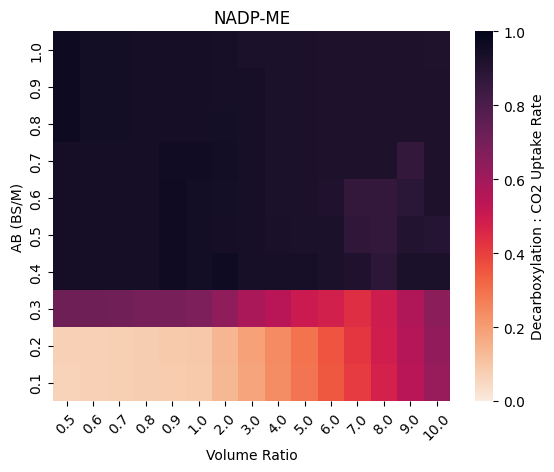

In [35]:
NADP_ME_pivot = df_250.pivot(index="AB (BS/M)", columns="Volume Ratio", values="NADP-ME")
NADP_ME_pivot.sort_index( ascending=False, inplace = True)
sns.heatmap(NADP_ME_pivot, cmap = "rocket_r", cbar_kws={'label': 'Decarboxylation : CO2 Uptake Rate'}, vmin=0, vmax=1).set(title = "NADP-ME")
plt.xticks(rotation=45)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, '0.5'),
  Text(1.5, 0, '0.6'),
  Text(2.5, 0, '0.7'),
  Text(3.5, 0, '0.8'),
  Text(4.5, 0, '0.9'),
  Text(5.5, 0, '1.0'),
  Text(6.5, 0, '2.0'),
  Text(7.5, 0, '3.0'),
  Text(8.5, 0, '4.0'),
  Text(9.5, 0, '5.0'),
  Text(10.5, 0, '6.0'),
  Text(11.5, 0, '7.0'),
  Text(12.5, 0, '8.0'),
  Text(13.5, 0, '9.0'),
  Text(14.5, 0, '10.0')])

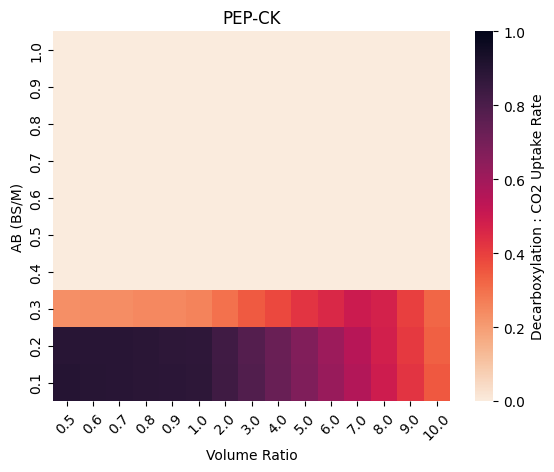

In [36]:
PEP_CK_pivot = df_250.pivot(index="AB (BS/M)", columns="Volume Ratio", values="PEP-CK")
PEP_CK_pivot.sort_index( ascending=False, inplace = True)
sns.heatmap(PEP_CK_pivot, cmap = "rocket_r", cbar_kws={'label': 'Decarboxylation : CO2 Uptake Rate'}, vmin=0, vmax=1).set(title = "PEP-CK")
plt.xticks(rotation=45)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, '0.5'),
  Text(1.5, 0, '0.6'),
  Text(2.5, 0, '0.7'),
  Text(3.5, 0, '0.8'),
  Text(4.5, 0, '0.9'),
  Text(5.5, 0, '1.0'),
  Text(6.5, 0, '2.0'),
  Text(7.5, 0, '3.0'),
  Text(8.5, 0, '4.0'),
  Text(9.5, 0, '5.0'),
  Text(10.5, 0, '6.0'),
  Text(11.5, 0, '7.0'),
  Text(12.5, 0, '8.0'),
  Text(13.5, 0, '9.0'),
  Text(14.5, 0, '10.0')])

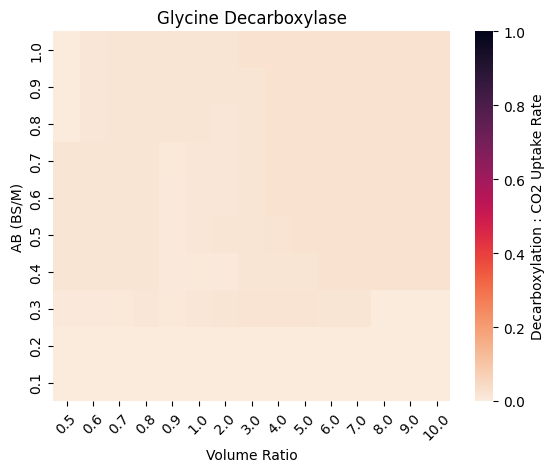

In [37]:
GLY_DX_pivot = df_250.pivot(index="AB (BS/M)", columns="Volume Ratio", values="GLY-DX")
GLY_DX_pivot.sort_index(ascending=False, inplace=True)
sns.heatmap(GLY_DX_pivot, cmap="rocket_r", cbar_kws={'label': 'Decarboxylation : CO2 Uptake Rate'}, vmin=0, vmax=1).set(
    title="Glycine Decarboxylase")
plt.xticks(rotation=45)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, '0.5'),
  Text(1.5, 0, '0.6'),
  Text(2.5, 0, '0.7'),
  Text(3.5, 0, '0.8'),
  Text(4.5, 0, '0.9'),
  Text(5.5, 0, '1.0'),
  Text(6.5, 0, '2.0'),
  Text(7.5, 0, '3.0'),
  Text(8.5, 0, '4.0'),
  Text(9.5, 0, '5.0'),
  Text(10.5, 0, '6.0'),
  Text(11.5, 0, '7.0'),
  Text(12.5, 0, '8.0'),
  Text(13.5, 0, '9.0'),
  Text(14.5, 0, '10.0')])

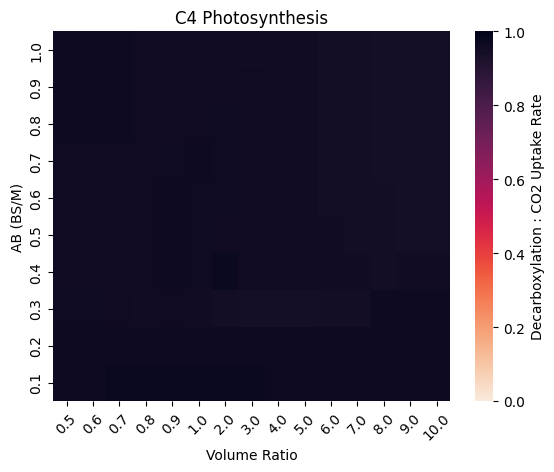

In [38]:
C4_pivot = df_250.pivot(index="AB (BS/M)", columns="Volume Ratio", values="C4 Photosynthesis")
C4_pivot.sort_index( ascending=False, inplace = True)
sns.heatmap(C4_pivot, cmap = "rocket_r", cbar_kws={'label': 'Decarboxylation : CO2 Uptake Rate'}, vmin=0, vmax=1).set(title = "C4 Photosynthesis")
plt.xticks(rotation=45)

#### $P_{Total} = 500 \mu mol s^{-1}$

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, '0.5'),
  Text(1.5, 0, '0.6'),
  Text(2.5, 0, '0.7'),
  Text(3.5, 0, '0.8'),
  Text(4.5, 0, '0.9'),
  Text(5.5, 0, '1.0'),
  Text(6.5, 0, '2.0'),
  Text(7.5, 0, '3.0'),
  Text(8.5, 0, '4.0'),
  Text(9.5, 0, '5.0'),
  Text(10.5, 0, '6.0'),
  Text(11.5, 0, '7.0'),
  Text(12.5, 0, '8.0'),
  Text(13.5, 0, '9.0'),
  Text(14.5, 0, '10.0')])

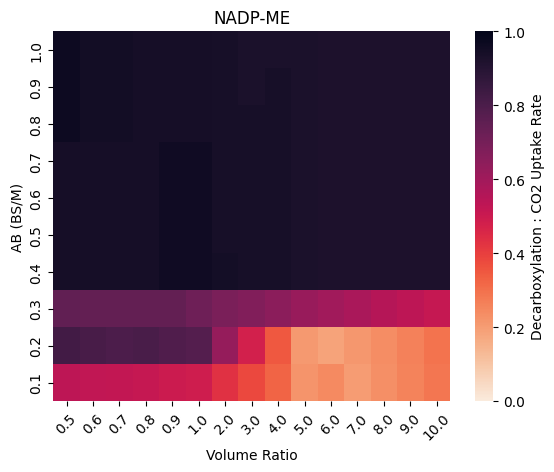

In [39]:
NADP_ME_pivot = df_500.pivot(index="AB (BS/M)", columns="Volume Ratio", values="NADP-ME")
NADP_ME_pivot.sort_index( ascending=False, inplace = True)
sns.heatmap(NADP_ME_pivot, cmap = "rocket_r", cbar_kws={'label': 'Decarboxylation : CO2 Uptake Rate'}, vmin=0, vmax=1).set(title = "NADP-ME")
plt.xticks(rotation=45)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, '0.5'),
  Text(1.5, 0, '0.6'),
  Text(2.5, 0, '0.7'),
  Text(3.5, 0, '0.8'),
  Text(4.5, 0, '0.9'),
  Text(5.5, 0, '1.0'),
  Text(6.5, 0, '2.0'),
  Text(7.5, 0, '3.0'),
  Text(8.5, 0, '4.0'),
  Text(9.5, 0, '5.0'),
  Text(10.5, 0, '6.0'),
  Text(11.5, 0, '7.0'),
  Text(12.5, 0, '8.0'),
  Text(13.5, 0, '9.0'),
  Text(14.5, 0, '10.0')])

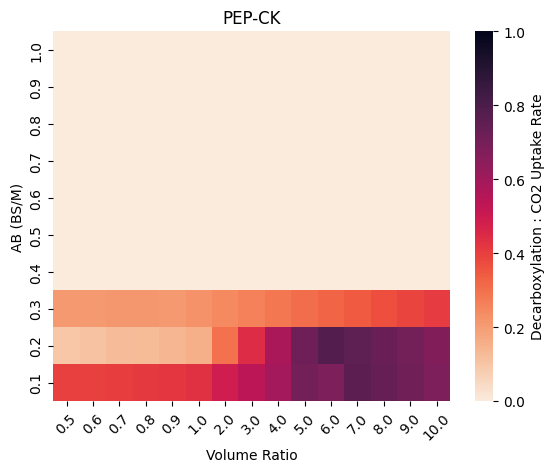

In [40]:
PEP_CK_pivot = df_500.pivot(index="AB (BS/M)", columns="Volume Ratio", values="PEP-CK")
PEP_CK_pivot.sort_index( ascending=False, inplace = True)
sns.heatmap(PEP_CK_pivot, cmap = "rocket_r", cbar_kws={'label': 'Decarboxylation : CO2 Uptake Rate'}, vmin=0, vmax=1).set(title = "PEP-CK")
plt.xticks(rotation=45)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, '0.5'),
  Text(1.5, 0, '0.6'),
  Text(2.5, 0, '0.7'),
  Text(3.5, 0, '0.8'),
  Text(4.5, 0, '0.9'),
  Text(5.5, 0, '1.0'),
  Text(6.5, 0, '2.0'),
  Text(7.5, 0, '3.0'),
  Text(8.5, 0, '4.0'),
  Text(9.5, 0, '5.0'),
  Text(10.5, 0, '6.0'),
  Text(11.5, 0, '7.0'),
  Text(12.5, 0, '8.0'),
  Text(13.5, 0, '9.0'),
  Text(14.5, 0, '10.0')])

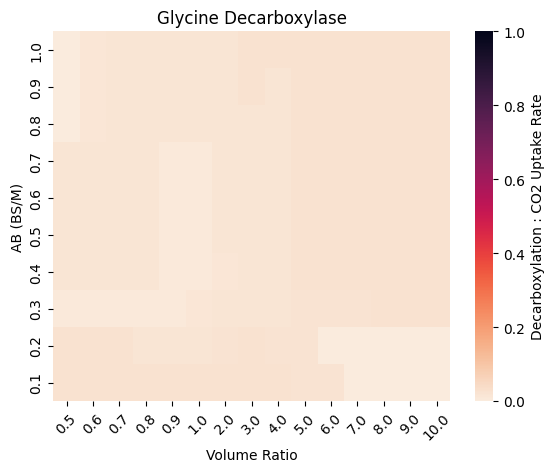

In [41]:
GLY_DX_pivot = df_500.pivot(index="AB (BS/M)", columns="Volume Ratio", values="GLY-DX")
GLY_DX_pivot.sort_index(ascending=False, inplace=True)
sns.heatmap(GLY_DX_pivot, cmap="rocket_r", cbar_kws={'label': 'Decarboxylation : CO2 Uptake Rate'}, vmin=0, vmax=1).set(
    title="Glycine Decarboxylase")
plt.xticks(rotation=45)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, '0.5'),
  Text(1.5, 0, '0.6'),
  Text(2.5, 0, '0.7'),
  Text(3.5, 0, '0.8'),
  Text(4.5, 0, '0.9'),
  Text(5.5, 0, '1.0'),
  Text(6.5, 0, '2.0'),
  Text(7.5, 0, '3.0'),
  Text(8.5, 0, '4.0'),
  Text(9.5, 0, '5.0'),
  Text(10.5, 0, '6.0'),
  Text(11.5, 0, '7.0'),
  Text(12.5, 0, '8.0'),
  Text(13.5, 0, '9.0'),
  Text(14.5, 0, '10.0')])

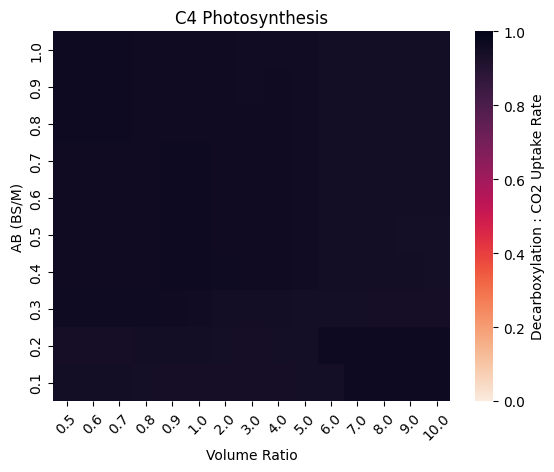

In [42]:
C4_pivot = df_500.pivot(index="AB (BS/M)", columns="Volume Ratio", values="C4 Photosynthesis")
C4_pivot.sort_index( ascending=False, inplace = True)
sns.heatmap(C4_pivot, cmap = "rocket_r", cbar_kws={'label': 'Decarboxylation : CO2 Uptake Rate'}, vmin=0, vmax=1).set(title = "C4 Photosynthesis")
plt.xticks(rotation=45)

#### $P_{Total} = 750 \mu mol s^{-1}$

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, '0.5'),
  Text(1.5, 0, '0.6'),
  Text(2.5, 0, '0.7'),
  Text(3.5, 0, '0.8'),
  Text(4.5, 0, '0.9'),
  Text(5.5, 0, '1.0'),
  Text(6.5, 0, '2.0'),
  Text(7.5, 0, '3.0'),
  Text(8.5, 0, '4.0'),
  Text(9.5, 0, '5.0'),
  Text(10.5, 0, '6.0'),
  Text(11.5, 0, '7.0'),
  Text(12.5, 0, '8.0'),
  Text(13.5, 0, '9.0'),
  Text(14.5, 0, '10.0')])

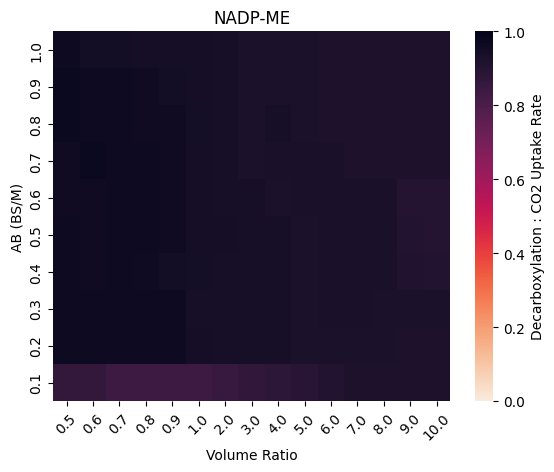

In [43]:
NADP_ME_pivot = df_750.pivot(index="AB (BS/M)", columns="Volume Ratio", values="NADP-ME")
NADP_ME_pivot.sort_index( ascending=False, inplace = True)
sns.heatmap(NADP_ME_pivot, cmap = "rocket_r", cbar_kws={'label': 'Decarboxylation : CO2 Uptake Rate'}, vmin=0, vmax=1).set(title = "NADP-ME")
plt.xticks(rotation=45)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, '0.5'),
  Text(1.5, 0, '0.6'),
  Text(2.5, 0, '0.7'),
  Text(3.5, 0, '0.8'),
  Text(4.5, 0, '0.9'),
  Text(5.5, 0, '1.0'),
  Text(6.5, 0, '2.0'),
  Text(7.5, 0, '3.0'),
  Text(8.5, 0, '4.0'),
  Text(9.5, 0, '5.0'),
  Text(10.5, 0, '6.0'),
  Text(11.5, 0, '7.0'),
  Text(12.5, 0, '8.0'),
  Text(13.5, 0, '9.0'),
  Text(14.5, 0, '10.0')])

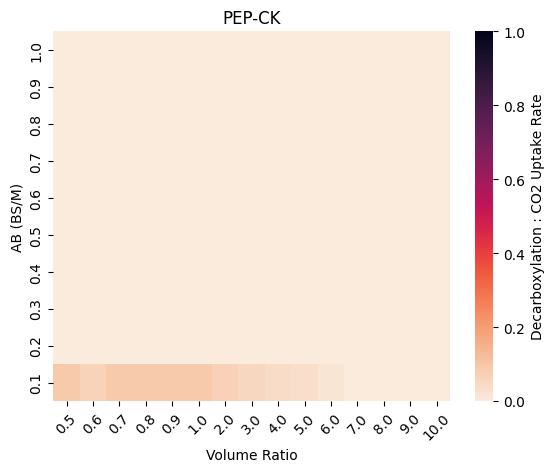

In [44]:
PEP_CK_pivot = df_750.pivot(index="AB (BS/M)", columns="Volume Ratio", values="PEP-CK")
PEP_CK_pivot.sort_index( ascending=False, inplace = True)
sns.heatmap(PEP_CK_pivot, cmap = "rocket_r", cbar_kws={'label': 'Decarboxylation : CO2 Uptake Rate'}, vmin=0, vmax=1).set(title = "PEP-CK")
plt.xticks(rotation=45)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, '0.5'),
  Text(1.5, 0, '0.6'),
  Text(2.5, 0, '0.7'),
  Text(3.5, 0, '0.8'),
  Text(4.5, 0, '0.9'),
  Text(5.5, 0, '1.0'),
  Text(6.5, 0, '2.0'),
  Text(7.5, 0, '3.0'),
  Text(8.5, 0, '4.0'),
  Text(9.5, 0, '5.0'),
  Text(10.5, 0, '6.0'),
  Text(11.5, 0, '7.0'),
  Text(12.5, 0, '8.0'),
  Text(13.5, 0, '9.0'),
  Text(14.5, 0, '10.0')])

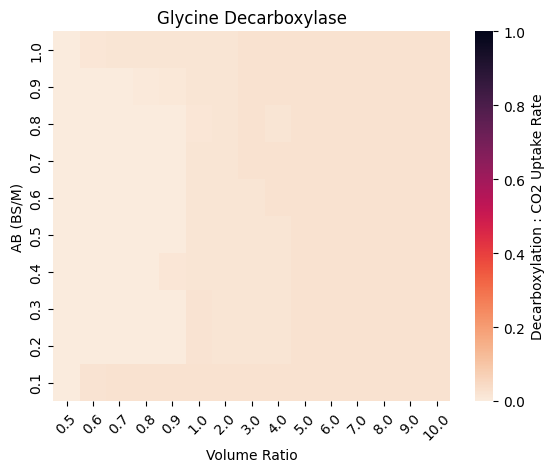

In [45]:
GLY_DX_pivot = df_750.pivot(index="AB (BS/M)", columns="Volume Ratio", values="GLY-DX")
GLY_DX_pivot.sort_index(ascending=False, inplace=True)
sns.heatmap(GLY_DX_pivot, cmap="rocket_r", cbar_kws={'label': 'Decarboxylation : CO2 Uptake Rate'}, vmin=0, vmax=1).set(
    title="Glycine Decarboxylase")
plt.xticks(rotation=45)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, '0.5'),
  Text(1.5, 0, '0.6'),
  Text(2.5, 0, '0.7'),
  Text(3.5, 0, '0.8'),
  Text(4.5, 0, '0.9'),
  Text(5.5, 0, '1.0'),
  Text(6.5, 0, '2.0'),
  Text(7.5, 0, '3.0'),
  Text(8.5, 0, '4.0'),
  Text(9.5, 0, '5.0'),
  Text(10.5, 0, '6.0'),
  Text(11.5, 0, '7.0'),
  Text(12.5, 0, '8.0'),
  Text(13.5, 0, '9.0'),
  Text(14.5, 0, '10.0')])

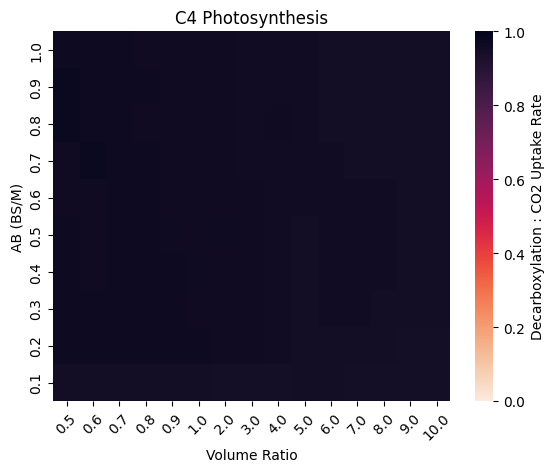

In [46]:
C4_pivot = df_750.pivot(index="AB (BS/M)", columns="Volume Ratio", values="C4 Photosynthesis")
C4_pivot.sort_index( ascending=False, inplace = True)
sns.heatmap(C4_pivot, cmap = "rocket_r", cbar_kws={'label': 'Decarboxylation : CO2 Uptake Rate'}, vmin=0, vmax=1).set(title = "C4 Photosynthesis")
plt.xticks(rotation=45)